In [1]:
# Importing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder

import glob
import time

In [2]:
start_time = time.time()
useful_cols = ['WAGP','SEX', 'AGEP','RAC1P','RAC3P','SCHL', 'WKW','WKHP','OCCP','POWSP','REGION']
path = r'data'
PUS_18_13 = pd.concat([pd.read_csv(f, usecols = useful_cols) for f in glob.glob(path + "/*.csv")],
                      ignore_index=True)
print (PUS_18_13.shape)
print(" %s min" % round(((time.time() - start_time)/60),2))

(18973476, 11)
 3.02 min


In [3]:
PUS_18_13.columns

Index(['REGION', 'AGEP', 'SCHL', 'SEX', 'WAGP', 'WKHP', 'WKW', 'OCCP', 'POWSP',
       'RAC1P', 'RAC3P'],
      dtype='object')

In [4]:
PUS_18_13.describe()

,REGION,AGEP,SCHL,SEX,WAGP,WKHP,WKW,OCCP,POWSP,RAC1P,RAC3P
count,1.897348e+07,1.897348e+07,1.839731e+07,1.897348e+07,1.574302e+07,9.747443e+06,9.747443e+06,1.118794e+07,8.553913e+06,1.897348e+07,1.897348e+07
mean,2.663216e+00,4.110300e+01,1.600594e+01,1.511173e+00,2.784096e+04,3.805982e+01,1.881675e+00,4.288653e+03,2.798419e+01,1.892220e+00,2.822543e+00
std,1.022737e+00,2.360399e+01,5.638562e+00,4.998752e-01,5.158834e+04,1.329897e+01,1.617851e+00,2.630202e+03,1.769987e+01,2.104585e+00,6.694164e+00
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.000000e+00,2.100000e+01,1.400000e+01,1.000000e+00,0.000000e+00,3.200000e+01,1.000000e+00,2.310000e+03,1.200000e+01,1.000000e+00,1.000000e+00
50%,3.000000e+00,4.200000e+01,1.700000e+01,2.000000e+00,7.000000e+03,4.000000e+01,1.000000e+00,4.250000e+03,2.700000e+01,1.000000e+00,1.000000e+00
75%,3.000000e+00,6.000000e+01,2.000000e+01,2.000000e+00,4.000000e+04,4.300000e+01,2.000000e+00,5.700000e+03,4.200000e+01,1.000000e+00,1.000000e+00
max,4.000000e+00,9.700000e+01,2.400000e+01,2.000000e+00,7.360000e+05,9.900000e+01,6.000000e+00,9.920000e+03,5.550000e+02,9.000000e+00,1.000000e+02


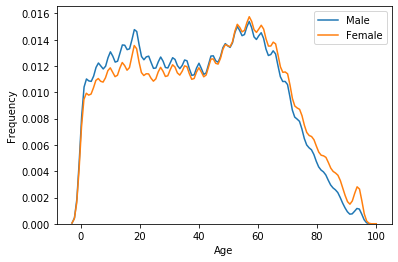

In [5]:
g = sns.kdeplot(PUS_18_13["AGEP"][(PUS_18_13["SEX"] == 1) & (PUS_18_13["AGEP"].notnull())])
g = sns.kdeplot(PUS_18_13["AGEP"][(PUS_18_13["SEX"] == 2) & (PUS_18_13["AGEP"].notnull())])
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g=g.legend(["Male","Female"])

Text(0, 0.5, 'Frequency')

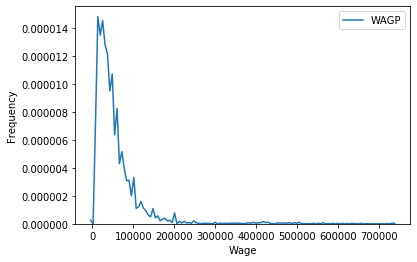

In [6]:
g = sns.kdeplot(PUS_18_13["WAGP"][(PUS_18_13["WAGP"] > 0) & (PUS_18_13["AGEP"] > 18)])
g.set_xlabel("Wage")
g.set_ylabel("Frequency")

#### Full-Time Detection

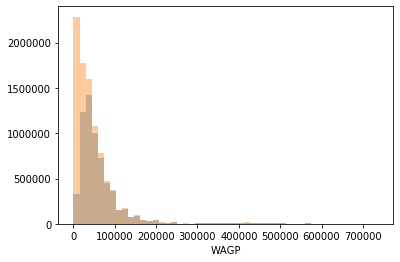

In [7]:
g = sns.distplot(PUS_18_13["WAGP"][(PUS_18_13["WAGP"] > 0) & (PUS_18_13["WKW"] < 4) & (PUS_18_13["WKHP"]  >= 35)], kde=False)
g = sns.distplot(PUS_18_13["WAGP"][(PUS_18_13["WAGP"] > 0)], kde=False)

In [8]:
# define function to seperate people who've worked more than 40 weeks / year
def full_time_detect(df):
    # remove rows of people who work under 40 weeks in a year
    df['WKW'] = df['WKW'].map(lambda y: 1 if y < 4
                              else 0)
    df = df.loc[df.WKW != 0].copy()

    # remove rows of people who work under 35 hours a week
    df['WKHP'] = df['WKHP'].map(lambda y: 1 if y >= 35
                                else 0)
    df = df.loc[df.WKHP != 0].copy()
    return df

In [9]:
ft_test = PUS_18_13.copy()
ft_test = full_time_detect(ft_test)
print(ft_test.shape)
ft_test.describe()

(6570187, 11)


,REGION,AGEP,SCHL,SEX,WAGP,WKHP,WKW,OCCP,POWSP,RAC1P,RAC3P
count,6.570187e+06,6.570187e+06,6.570187e+06,6.570187e+06,6.570187e+06,6570187.0,6570187.0,6.570187e+06,6.351093e+06,6.570187e+06,6.570187e+06
mean,2.642465e+00,4.435680e+01,1.877676e+01,1.433771e+00,5.971916e+04,1.0,1.0,4.053146e+03,2.807777e+01,1.823275e+00,2.577079e+00
std,1.024261e+00,1.306259e+01,3.275715e+00,4.955943e-01,6.456433e+04,0.0,0.0,2.742360e+03,1.779300e+01,2.011983e+00,5.947349e+00
min,1.000000e+00,1.600000e+01,1.000000e+00,1.000000e+00,0.000000e+00,1.0,1.0,1.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.000000e+00,3.300000e+01,1.600000e+01,1.000000e+00,2.630000e+04,1.0,1.0,1.650000e+03,1.200000e+01,1.000000e+00,1.000000e+00
50%,3.000000e+00,4.500000e+01,1.900000e+01,1.000000e+00,4.500000e+04,1.0,1.0,4.110000e+03,2.700000e+01,1.000000e+00,1.000000e+00
75%,3.000000e+00,5.500000e+01,2.100000e+01,2.000000e+00,7.000000e+04,1.0,1.0,5.740000e+03,4.200000e+01,1.000000e+00,1.000000e+00
max,4.000000e+00,9.600000e+01,2.400000e+01,2.000000e+00,7.360000e+05,1.0,1.0,9.830000e+03,5.550000e+02,9.000000e+00,1.000000e+02


## Outlier Testing

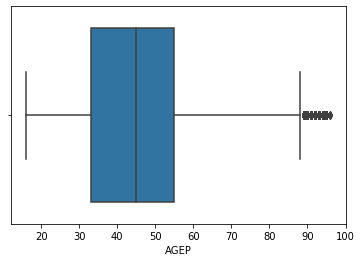

In [10]:
ax = sns.boxplot(x=ft_test["AGEP"])

In [11]:
test_age_IQR = np.percentile(ft_test.AGEP, 75) - np.percentile(ft_test.AGEP, 25) 
test_age_upper = np.percentile(ft_test.AGEP, 75) + test_age_IQR*3
test_age_lower = np.percentile(ft_test.AGEP, 25) - test_age_IQR*3
print ("AGE IQR: " , test_age_IQR," Upper: " , test_age_upper ," Lower: " , test_age_lower)

AGE IQR:  22.0  Upper:  121.0  Lower:  -33.0


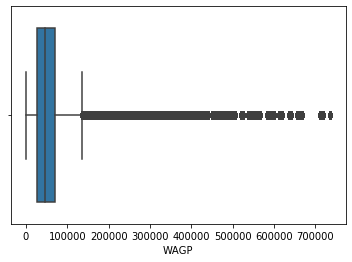

In [12]:
ax = sns.boxplot(x=ft_test["WAGP"])

In [13]:
test_wage_IQR = np.percentile(ft_test.WAGP, 75) - np.percentile(ft_test.WAGP, 25) 
test_wage_upper = np.percentile(ft_test.WAGP, 75) + test_wage_IQR*3
test_wage_lower = np.percentile(ft_test.WAGP, 25) - test_wage_IQR*3
print ("Wage IQR: " , test_wage_IQR," Upper: " , test_wage_upper ," Lower: " , test_wage_lower)

Wage IQR:  43700.0  Upper:  201100.0  Lower:  -104800.0


In [14]:
def outlier_remove(df):
    wage_IQR = np.percentile(df.WAGP, 75) - np.percentile(df.WAGP, 25) 
    wage_upper = np.percentile(df.WAGP, 75) + wage_IQR*3
    wage_lower = np.percentile(df.WAGP, 25) - wage_IQR*3
    
    age_IQR = np.percentile(df.AGEP, 75) - np.percentile(df.AGEP, 25) 
    age_upper = np.percentile(df.AGEP, 75) + age_IQR*3
    age_lower = np.percentile(df.AGEP, 25) - age_IQR*3
    
    df = df.loc[df.WAGP >= 12500].copy()
    df = df.loc[df.WAGP <= wage_upper].copy()
    df = df.loc[df.AGEP >= age_lower].copy()
    df = df.loc[df.AGEP <= age_upper].copy()
    
    return df

In [15]:
outlier_test = ft_test.copy()
outlier_test = outlier_remove(outlier_test)
print(outlier_test.shape)

(5870107, 11)


[(12500, 250000)]

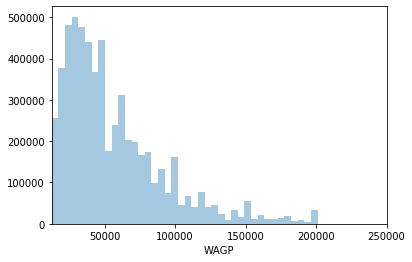

In [16]:
ax = sns.distplot(outlier_test["WAGP"], bins=40, kde=False)
ax.set(xlim=(12500, 250000))

##### Age Bins

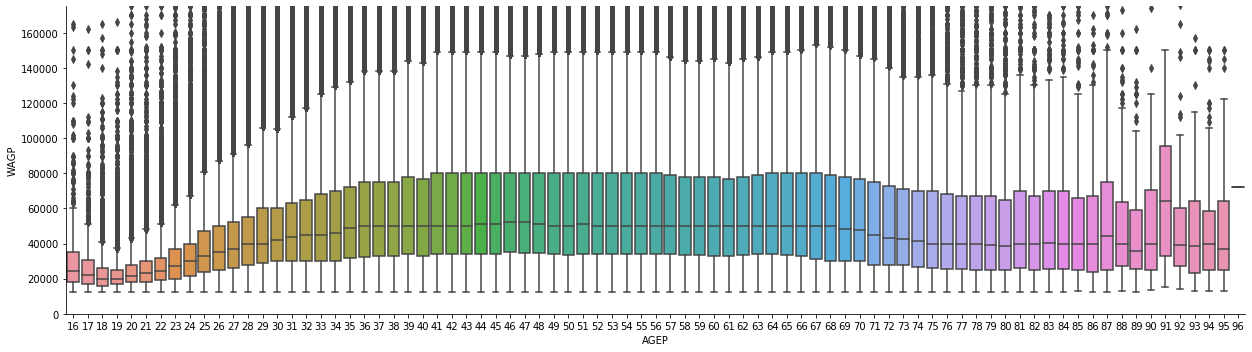

In [17]:
g = sns.catplot(y="WAGP", x="AGEP", data=outlier_test, kind="box", aspect = 3.5)
g.set(ylim=(0, 175000))

In [18]:
def age_bins(df):
    df['AGEB'] = df['AGEP'].map(lambda y: "16-23" if y < 24
                                else "24-28" if y < 29
                                else "29-34" if y < 35
                                else "35-39" if y < 40
                                else "40-49" if y < 50
                                else "50-59" if y < 60
                                else "60-69" if y < 70
                                else "70+")
    return df

In [19]:
age_test = outlier_test.copy()
age_test.sort_values(by=['AGEP'], ascending=True, inplace=True)

In [20]:
age_bins(age_test)
print("Age :", age_test.AGEB.unique())

Age : ['16-23' '24-28' '29-34' '35-39' '40-49' '50-59' '60-69' '70+']


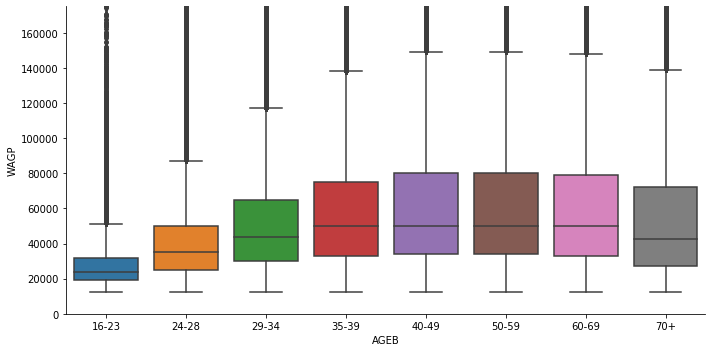

In [21]:
g = sns.catplot(y="WAGP", x="AGEB", data=age_test, kind="box", aspect = 2)
g.set(ylim=(0, 175000))

In [22]:
age_test['AGEB'].value_counts()

50-59    1480292
40-49    1365948
29-34     795777
60-69     672600
35-39     649257
24-28     584020
16-23     242224
70+        79989
Name: AGEB, dtype: int64

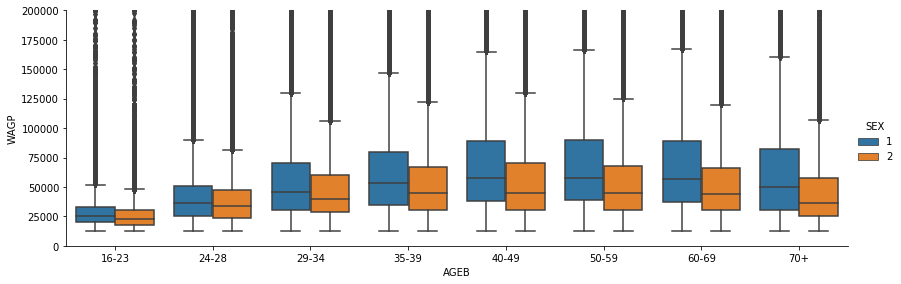

In [23]:
g = sns.catplot(y="WAGP", x="AGEB", data=age_test, kind="box", height = 4, aspect = 3, hue = "SEX")
g.set(ylim=(0, 200000))

#### Education Split
- NH: No High-school Degree
- HS: Highschool Diploma (or GED)
- SC: Some College
- AS: Associate's degree
- BS: Bachelor's degree
- GD: Graduate Degree
- DR: Doctorate Degree

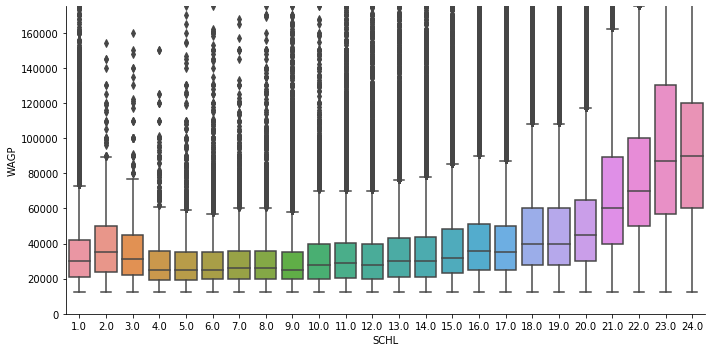

In [24]:
g = sns.catplot(y="WAGP", x="SCHL", data=age_test, kind="box", aspect = 2)
g.set(ylim=(0, 175000))

In [25]:
def edu_split(df):
    #split into degrees
    df['EDU'] = df['SCHL'].map(lambda y: 1 if y <=15 #didn't finish HS
                               else 2 if y <= 17 #HS degree
                                else 3 if y <= 19 #some college
                               else 4 if y == 20 #AS
                               else 5 if y == 21 #BS
                                else 6 if y == 22 #MS
                                else 7) #GS
    return df

In [26]:
edu_test = age_test.copy()
edu_test = edu_split(edu_test)
print("Edu :", edu_test.EDU.unique())

Edu : [1 2 3 4 6 5 7]


In [27]:
edu_sort = edu_test.groupby('EDU').median().sort_values(by=['WAGP']).reset_index()
edu_list = edu_sort['EDU'].tolist()

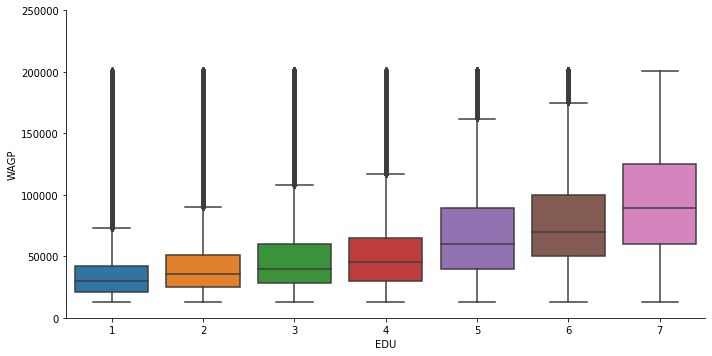

In [28]:
g = sns.catplot(y="WAGP", x="EDU", data=edu_test, kind="box", aspect = 2, order = edu_list)
g.set(ylim=(0, 250000))

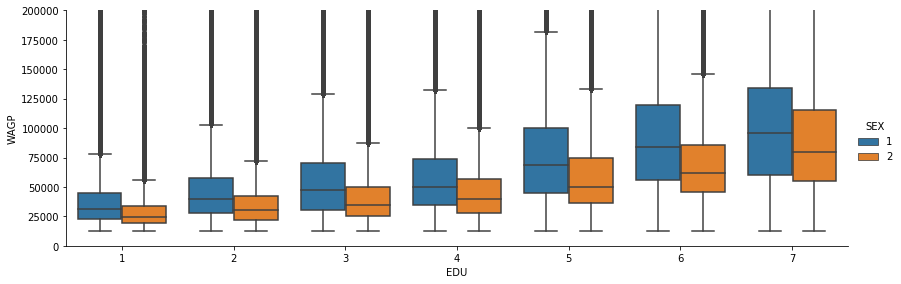

In [29]:
g = sns.catplot(y="WAGP", x="EDU", data=edu_test, kind="box", height = 4, aspect = 3, hue = "SEX", order = edu_list)
g.set(ylim=(0, 200000))

In [30]:
edu_test['EDU'].value_counts()

5    1409389
2    1385499
3    1251435
6     628704
4     582609
1     382447
7     230024
Name: EDU, dtype: int64

#### Occupation Split
- 0010-0960: Management, Business, and Financial Occupations
- 1005-1980: Computer, Engineering, and Science Occupations
- 2001-2970: Education, Legal, Community Service, Arts, and Media Occupations
- 3000-3550: Healthcare Practitioners and Technical Occupations
- 3601-4655: Service Occupations
- 4700-5940: Sales and Office Occupations
- 6005-7640: Natural Resources, Construction, and Maintenance Occupations
- 7700-8990: Production Occupations
- 9005-9760: Transportation and Material Moving Occupations
- 9800-9830: Military Specific Occupations

In [31]:
def int_occ_split(df):
    # split into occupational industries
    df['JOB'] = df['OCCP'].map(lambda y: "Business" if y <= 960
                                else "Science" if y <= 1980
                                else "Arts" if y <= 2970
                                else "Healthcare" if y <= 3550
                                else "Service" if y <= 4655
                                else "Sales" if y <= 5940
                                else "Maintenance" if y <= 7640
                                else "Production" if y <= 8990
                                else "Transportation" if y <= 9760
                                else "Military" if y <= 9830
                                else "UN")
    return df

In [32]:
int_occ_test = edu_test.copy()
int_occ_test = int_occ_split(int_occ_test)
print("Occ :", int_occ_test.JOB.unique())

Occ : ['Business' 'Healthcare' 'Service' 'Maintenance' 'Transportation' 'Arts'
 'Sales' 'Production' 'Science' 'Military']


In [33]:
int_occ_sort = int_occ_test.groupby('JOB').median().sort_values(by=['WAGP']).reset_index()
int_occ_list = int_occ_sort['JOB'].tolist()

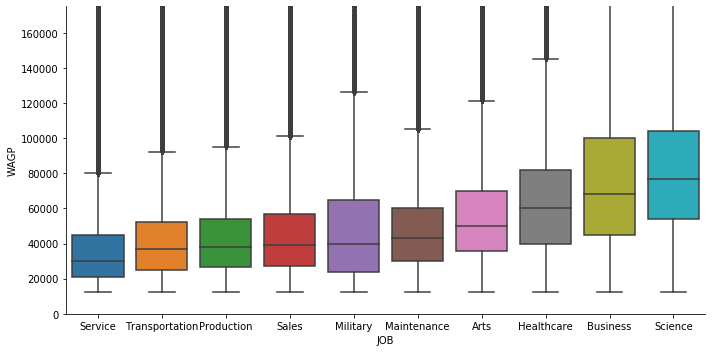

In [34]:
g = sns.catplot(y="WAGP", x="JOB", data=int_occ_test, kind="box", aspect = 2, order = int_occ_list)
g.set(ylim=(0, 175000))

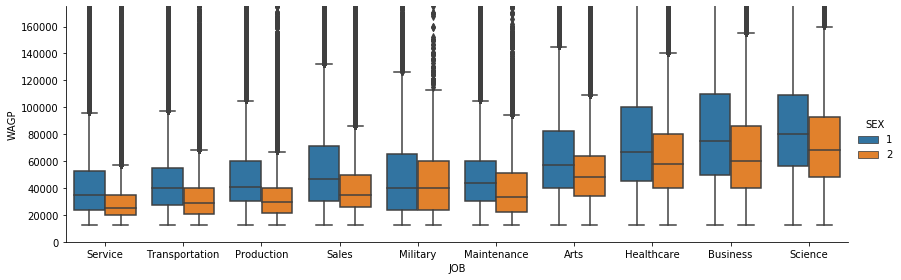

In [35]:
g = sns.catplot(y="WAGP", x="JOB", data=int_occ_test, kind="box", height = 4, aspect = 3, hue = "SEX", order = int_occ_list)
g.set(ylim=(0, 175000))

In [36]:
int_occ_test['JOB'].value_counts()

Sales             1287884
Business          1078869
Service            688923
Arts               665866
Maintenance        550769
Science            432793
Production         408831
Healthcare         365863
Transportation     362659
Military            27650
Name: JOB, dtype: int64

In [37]:
def occ_split(df):
    # split into occupational industries
    df['JOB'] = df['OCCP'].map(lambda y: 2 if y <= 960 #Business
                                else 1 if y <= 1980 #Science
                                else 4 if y <= 2970 #Arts
                                else 3 if y <= 3550 # Healthcare
                                else 10 if y <= 4655 #Service
                                else 7 if y <= 5940 #Sales
                                else 5 if y <= 7640 #Maintenance
                                else 8 if y <= 8990 #Production
                                else 9 if y <= 9760 #Transportation
                                else 6 if y <= 9830 #Military
                                else 11) #Undefined
    return df

In [38]:
occ_test = edu_test.copy()
occ_test = occ_split(occ_test)
print("Occ :", occ_test.JOB.unique())

Occ : [ 2  3 10  5  9  4  7  8  1  6]


#### State - POWSP

In [39]:
int_state_sort = occ_test.groupby('POWSP').median().reset_index()
int_state_sort['reg_code'] = ['3', '4', '4', '3', '4', '4', '1', '3', '3', '3',
                          '3', '4', '4', '2', '2', '2', '2', '3', '3', '1',
                          '3', '1', '2', '2', '3', '2', '4', '2', '4', '1',
                          '1', '4', '1', '3', '2', '2', '3', '4', '1', '1',
                          '3', '2', '3', '3', '4', '1', '3', '4', '3', '2',
                          '4', '5', '5', '5', '5', '5', '5', '5', '5']
int_state_sort = int_state_sort.sort_values(by=['WAGP'])
int_state_list = int_state_sort['POWSP'].tolist()

In [40]:
reg_sort = int_state_sort.sort_values(by=['reg_code'])
reg_list = reg_sort['POWSP'].tolist()

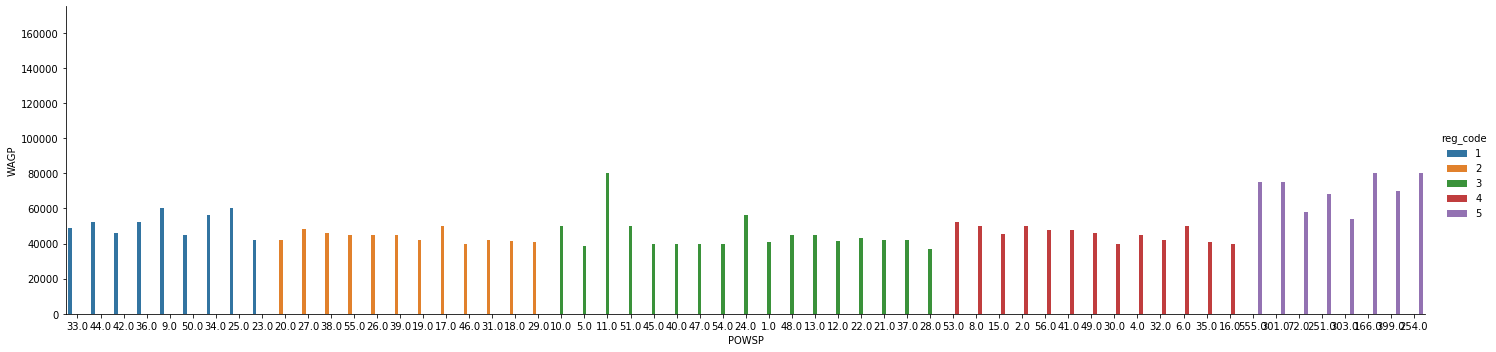

In [41]:
g = sns.catplot(y="WAGP", x="POWSP", hue = 'reg_code', data=reg_sort, kind="bar", aspect = 4, order = reg_list)
g.set(ylim=(0, 175000))

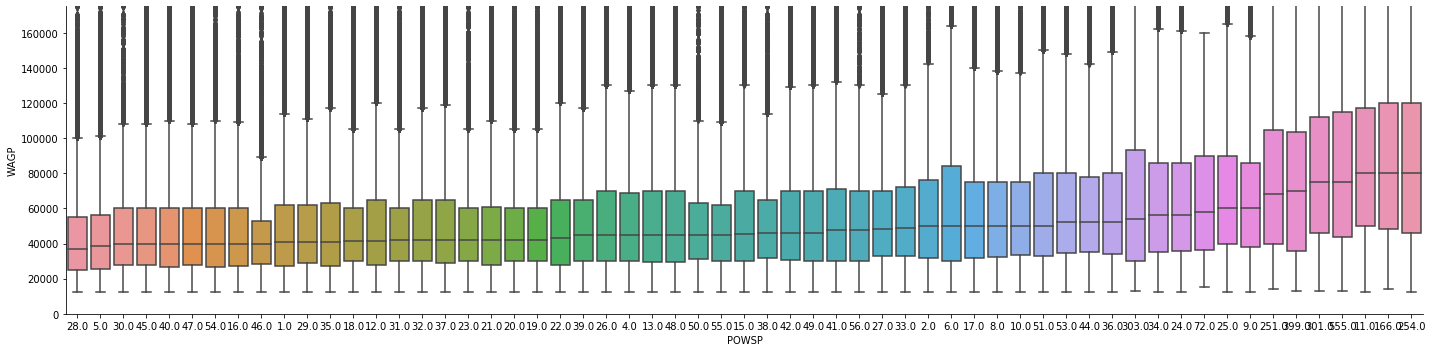

In [42]:
g = sns.catplot(y="WAGP", x="POWSP", data=occ_test, kind="box", aspect = 4, order = int_state_list)
g.set(ylim=(0, 175000))

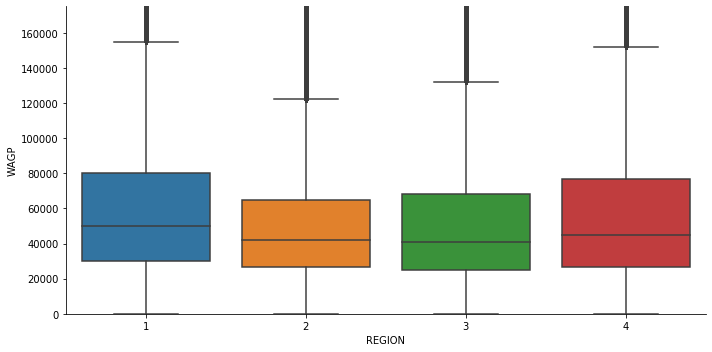

In [43]:
g = sns.catplot(y="WAGP", x="REGION", data=ft_test, kind="box", aspect = 2)
g.set(ylim=(0, 175000))

In [44]:
print (int_state_list)

[28.0, 5.0, 30.0, 45.0, 40.0, 47.0, 54.0, 16.0, 46.0, 1.0, 29.0, 35.0, 18.0, 12.0, 31.0, 32.0, 37.0, 23.0, 21.0, 20.0, 19.0, 22.0, 39.0, 26.0, 4.0, 13.0, 48.0, 50.0, 55.0, 15.0, 38.0, 42.0, 49.0, 41.0, 56.0, 27.0, 33.0, 2.0, 6.0, 17.0, 8.0, 10.0, 51.0, 53.0, 44.0, 36.0, 303.0, 34.0, 24.0, 72.0, 25.0, 9.0, 251.0, 399.0, 301.0, 555.0, 11.0, 166.0, 254.0]


In [45]:
def state_split(df):
    # split into higher paying states
    df['STSP'] = df['POWSP'].map(lambda y: 1 if y in [17.0, 8.0, 10.0, 51.0, 53.0, 44.0, 36.0, 303.0, 34.0, 24.0, 72.0, 25.0, 9.0, 251.0, 399.0, 301.0, 555.0, 11.0, 166.0, 254.0]
                                 else 2 if y in [50.0, 55.0, 15.0, 38.0, 42.0, 49.0, 41.0, 56.0, 27.0, 33.0, 2.0,6.0]
                                 else 3 if y in [23.0, 21.0, 20.0, 19.0, 22.0, 39.0, 26.0, 4.0,13.0, 48.0, ]
                                 else 4 if y in [28.0, 5.0, 30.0, 45.0, 40.0, 47.0, 54.0, 16.0, 46.0, 1.0, 29.0, 35.0, 18.0, 12.0, 31.0,32.0, 37.0, ]
                                 else 5)
    test = df.loc[df['STSP'] == 5].copy()
    df = df.loc[df['STSP'] != 5]
    test['STSP'] = test['REGION'].map(lambda y: 1 if y == 1
                                      else 2 if y == 4
                                      else 3 if y == 2
                                      else 4 if y == 3
                                      else 10)
    df = pd.concat([df, test])

    return df

In [46]:
state_test = occ_test.copy()
state_test = state_split(state_test)
print("State :", state_test.STSP.unique())
state_test['STSP'].value_counts()

State : [2 1 4 3]


1    1584412
3    1473381
4    1455582
2    1356732
Name: STSP, dtype: int64

In [47]:
state_sort = state_test.groupby('STSP').median().sort_values(by=['WAGP']).reset_index()
state_list = state_sort['STSP'].tolist()

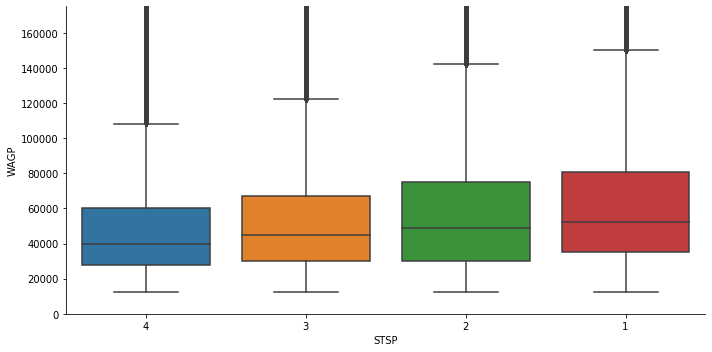

In [48]:
g = sns.catplot(y="WAGP", x="STSP", data=state_test, kind="box", aspect = 2, order = state_list)
g.set(ylim=(0, 175000))

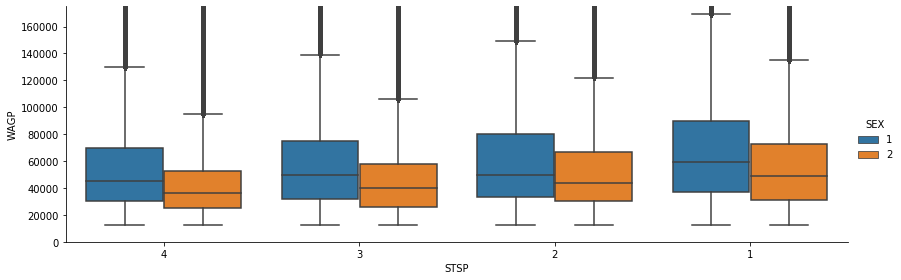

In [49]:
g = sns.catplot(y="WAGP", x="STSP", data=state_test, kind="box", height = 4, aspect = 3, hue = "SEX", order = state_list)
g.set(ylim=(0, 175000))

#### Ethnicity - RAC1P

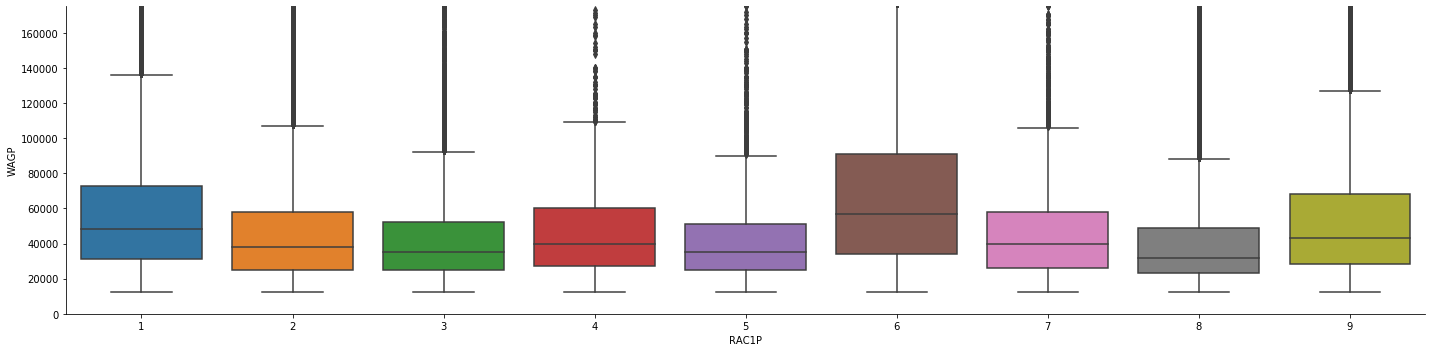

In [50]:
g = sns.catplot(y="WAGP", x="RAC1P", data=state_test, kind="box", aspect = 4)
g.set(ylim=(0, 175000))

In [51]:
state_test['RAC1P'].value_counts()

1    4613731
2     531194
6     332972
8     213146
9     120271
3      40507
7       9945
5       6321
4       2020
Name: RAC1P, dtype: int64

In [52]:
def int_race_split(df):
    # split into occupational industries
    df['RACE'] = df['RAC3P'].map(lambda y: "WHT" if y == 1
                               else "BLK" if y == 2
                               else "IND" if y == 3
                               else "ASN" if y <= 10
                               else "ISL" if y <= 14
                               else "NAN" if y == 15
                               else "WHT" if y <= 29
                               else "BLK" if y <= 38
                               else "IND" if y <= 41
                               else "ASN" if y <= 58
                               else "ISL" if y == 59
                               else "WHT" if y <= 70
                               else "ASN" if y == 71
                               else "WHT" if y <= 73
                               else "BLK" if y <= 75
                               else "ASN" if y <= 77
                               else "WHT" if y <= 89
                               else "BLK" if y <= 91
                               else "ASN" if y <= 98
                               else "ISL" if y == 99
                               else "WHT" if y == 100
                               else "UN")
    return df

In [53]:
int_race_test = state_test.copy()
int_race_test = int_race_split(int_race_test)
print("RACE :", int_race_test.RACE.unique())

RACE : ['WHT' 'BLK' 'NAN' 'ASN' 'ISL' 'IND']


In [54]:
int_race_test['RACE'].value_counts()

WHT    4714187
BLK     540687
ASN     341008
NAN     213146
IND      50639
ISL      10440
Name: RACE, dtype: int64

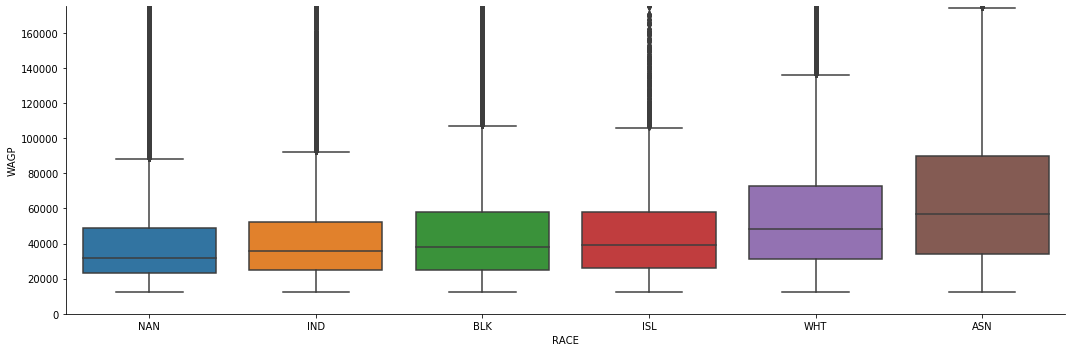

In [55]:
int_race_sort = int_race_test.groupby('RACE').median().sort_values(by=['WAGP']).reset_index()
int_race_list = int_race_sort['RACE'].tolist()
g = sns.catplot(y="WAGP", x="RACE", data=int_race_test, kind="box", aspect = 3, order = int_race_list)
g.set(ylim=(0, 175000))

In [56]:
def race_split(df):
    # split into occupational industries
    df['RACE'] = df['RAC3P'].map(lambda y: "WHT" if y == 1
                               else "BLK" if y == 2
                               else "IND" if y == 3
                               else "ASN" if y <= 10
                               else "ISL" if y <= 14
                               else "NAN" if y == 15
                               else "WHT" if y <= 29
                               else "BLK" if y <= 38
                               else "IND" if y <= 41
                               else "ASN" if y <= 58
                               else "ISL" if y == 59
                               else "WHT" if y <= 70
                               else "ASN" if y == 71
                               else "WHT" if y <= 73
                               else "BLK" if y <= 75
                               else "ASN" if y <= 77
                               else "WHT" if y <= 89
                               else "BLK" if y <= 91
                               else "ASN" if y <= 98
                               else "ISL" if y == 99
                               else "WHT" if y == 100
                               else "UN")
    df['RACE'] = df['RACE'].map(lambda y: 2 if y in ['WHT'] #white
                               else 3 if y in ['BLK'] #black
                               else 1 if y in ['ASN'] #asian
                               else 4) #Other
    return df

In [57]:
race_test = state_test.copy()
race_test = race_split(race_test)
print("RACE :", race_test.RACE.unique())

RACE : [2 3 4 1]


In [58]:
race_test['RACE'].value_counts()

2    4714187
3     540687
1     341008
4     274225
Name: RACE, dtype: int64

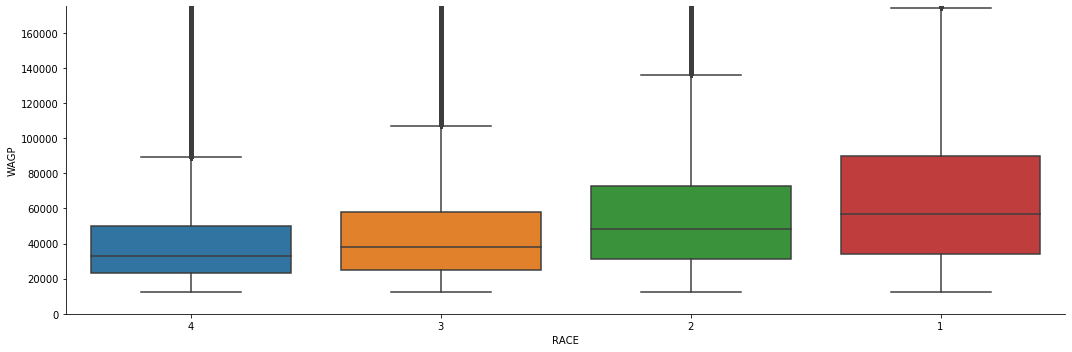

In [59]:
race_sort = race_test.groupby('RACE').median().sort_values(by=['WAGP']).reset_index()
race_list = race_sort['RACE'].tolist()
g = sns.catplot(y="WAGP", x="RACE", data=race_test, kind="box", aspect = 3, order = race_list)
g.set(ylim=(0, 175000))

#### Remove Columns

In [60]:
race_test.columns

Index(['REGION', 'AGEP', 'SCHL', 'SEX', 'WAGP', 'WKHP', 'WKW', 'OCCP', 'POWSP',
       'RAC1P', 'RAC3P', 'AGEB', 'EDU', 'JOB', 'STSP', 'RACE'],
      dtype='object')

In [61]:
race_test.describe(include='all')

,REGION,AGEP,SCHL,SEX,WAGP,WKHP,WKW,OCCP,POWSP,RAC1P,RAC3P,AGEB,EDU,JOB,STSP,RACE
count,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5870107.0,5870107.0,5.870107e+06,5.691810e+06,5.870107e+06,5.870107e+06,5870107,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50-59,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1480292,NaN,NaN,NaN,NaN
mean,2.638457e+00,4.417040e+01,1.880606e+01,1.443043e+00,5.612929e+04,1.0,1.0,4.076162e+03,2.810648e+01,1.821496e+00,2.575838e+00,NaN,3.691163e+00,5.402001e+00,2.477016e+00,2.127447e+00
std,1.022973e+00,1.288817e+01,3.208281e+00,4.967453e-01,3.576042e+04,0.0,0.0,2.752064e+03,1.761029e+01,2.008264e+00,5.963431e+00,NaN,1.633847e+00,2.909731e+00,1.133678e+00,5.664098e-01
min,1.000000e+00,1.600000e+01,1.000000e+00,1.000000e+00,1.250000e+04,1.0,1.0,1.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.000000e+00,3.300000e+01,1.600000e+01,1.000000e+00,3.000000e+04,1.0,1.0,1.720000e+03,1.200000e+01,1.000000e+00,1.000000e+00,NaN,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00
50%,3.000000e+00,4.500000e+01,1.900000e+01,1.000000e+00,4.600000e+04,1.0,1.0,4.110000e+03,2.800000e+01,1.000000e+00,1.000000e+00,NaN,3.000000e+00,5.000000e+00,2.000000e+00,2.000000e+00
75%,3.000000e+00,5.500000e+01,2.100000e+01,2.000000e+00,7.100000e+04,1.0,1.0,5.810000e+03,4.200000e+01,1.000000e+00,1.000000e+00,NaN,5.000000e+00,7.000000e+00,3.000000e+00,2.000000e+00


In [62]:
def remove_col(df):
    remove_cols = ['REGION','SCHL','WKHP','WKW','OCCP','POWSP','RAC1P','RAC3P']
    df = df.drop(remove_cols,axis=1)
    return df

In [63]:
remove_test = race_test.copy()
remove_test = remove_col(remove_test)
remove_test.describe(include='all')

,AGEP,SEX,WAGP,AGEB,EDU,JOB,STSP,RACE
count,5.870107e+06,5.870107e+06,5.870107e+06,5870107,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06
unique,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,50-59,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,1480292,NaN,NaN,NaN,NaN
mean,4.417040e+01,1.443043e+00,5.612929e+04,NaN,3.691163e+00,5.402001e+00,2.477016e+00,2.127447e+00
std,1.288817e+01,4.967453e-01,3.576042e+04,NaN,1.633847e+00,2.909731e+00,1.133678e+00,5.664098e-01
min,1.600000e+01,1.000000e+00,1.250000e+04,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,3.300000e+01,1.000000e+00,3.000000e+04,NaN,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00
50%,4.500000e+01,1.000000e+00,4.600000e+04,NaN,3.000000e+00,5.000000e+00,2.000000e+00,2.000000e+00
75%,5.500000e+01,2.000000e+00,7.100000e+04,NaN,5.000000e+00,7.000000e+00,3.000000e+00,2.000000e+00


### OHE Columns

In [64]:
def OHE_cat(df):
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    cat_col = [i for i in df.columns.tolist() if i not in ['WAGP','STSP']]
    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(df[cat_col]))
    OH_cols_train.index = df.index
    df = pd.concat([df, OH_cols_train], axis=1)
    df.drop(cat_col, axis=1, inplace=True)
    return df

In [65]:
OHE_test = remove_test.copy()
OHE_test = OHE_cat(OHE_test)
OHE_test.describe(include='all')

,WAGP,STSP,0,1,2,3,4,5,6,7,...,102,103,104,105,106,107,108,109,110,111
count,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,...,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06
mean,5.612929e+04,2.477016e+00,1.226553e-04,2.393483e-04,1.090951e-03,3.054800e-03,5.730219e-03,7.603780e-03,9.893687e-03,1.352854e-02,...,9.382606e-02,4.710306e-03,2.193970e-01,6.964626e-02,6.178065e-02,1.173612e-01,5.809230e-02,8.030837e-01,9.210854e-02,4.671550e-02
std,3.576042e+04,1.133678e+00,1.107431e-02,1.546903e-02,3.301153e-02,5.518576e-02,7.548102e-02,8.686751e-02,9.897375e-02,1.155228e-01,...,2.915866e-01,6.846985e-02,4.138381e-01,2.545499e-01,2.407567e-01,3.218503e-01,2.339179e-01,3.976686e-01,2.891791e-01,2.110288e-01
min,1.250000e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,4.600000e+04,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,7.100000e+04,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,2.010000e+05,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [66]:
OHE_names = remove_test.copy()
OH_encoder2 = OneHotEncoder(handle_unknown='ignore', sparse=False)
cat_col2 = [i for i in OHE_names.columns.tolist() if i not in ['WAGP','STSP']]
OH_cols_train2 = pd.DataFrame(OH_encoder2.fit_transform(OHE_names[cat_col2]))

OHEcol2 = OH_encoder2.get_feature_names(cat_col2)
OHEcols2 = pd.DataFrame()
OHEcols2['Features'] = OHEcol2

OHEcols2

,Features
0,AGEP_16
1,AGEP_17
2,AGEP_18
3,AGEP_19
4,AGEP_20
...,...
107,JOB_10
108,RACE_1
109,RACE_2
110,RACE_3


### Pipeline

In [67]:
def pp_pipeline(df):
    df = (df
          .pipe(full_time_detect)
          .pipe(outlier_remove)
          #.pipe(age_bins)
          .pipe(edu_split)
          .pipe(occ_split)
          .pipe(state_split)
          .pipe(race_split)
         .pipe(remove_col)
         #.pipe(OHE_cat)
         )
    return df

In [68]:
start_time = time.time()
pp_test = PUS_18_13.copy()
pp_test = pp_pipeline(pp_test)
print(" %s min" % round(((time.time() - start_time)/60),2))
pp_test.describe(include='all')

 0.99 min


,AGEP,SEX,WAGP,EDU,JOB,STSP,RACE
count,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06,5.870107e+06
mean,4.417040e+01,1.443043e+00,5.612929e+04,3.691163e+00,5.402001e+00,2.477016e+00,2.127447e+00
std,1.288817e+01,4.967453e-01,3.576042e+04,1.633847e+00,2.909731e+00,1.133678e+00,5.664098e-01
min,1.600000e+01,1.000000e+00,1.250000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,3.300000e+01,1.000000e+00,3.000000e+04,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00
50%,4.500000e+01,1.000000e+00,4.600000e+04,3.000000e+00,5.000000e+00,2.000000e+00,2.000000e+00
75%,5.500000e+01,2.000000e+00,7.100000e+04,5.000000e+00,7.000000e+00,3.000000e+00,2.000000e+00
max,9.600000e+01,2.000000e+00,2.010000e+05,7.000000e+00,1.000000e+01,4.000000e+00,4.000000e+00


In [69]:
split_test = pp_test.copy()
split = np.array_split(split_test, 6)
s1 = split[0]
s1.shape

(978352, 7)

In [70]:
y_full = s1['WAGP']
X_full = s1.drop(['WAGP'], axis=1)

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, random_state=0)

In [79]:
start_time = time.time()
random_forest = RandomForestRegressor(random_state=1, n_estimators=100, min_samples_split=2, min_samples_leaf=5)
random_forest.fit(X_train, y_train)
pred_valid = random_forest.predict(X_valid)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print("acc_random_forest: ", acc_random_forest)
print("MAE : ", mean_absolute_error(y_valid, pred_valid))
print(" %s min" % round(((time.time() - start_time)/60),2))

acc_random_forest:  44.17
MAE :  21293.601470378446
 3.67 min


In [99]:
preds_test = random_forest.predict(X_full).astype(int)
output = pd.DataFrame({'Index': X_full.index, 'WAG_pred': preds_test})
output.describe()

,Index,WAG_pred
count,978352.000000,978352.000000
mean,1.436041,58812.847222
std,0.495893,25191.852984
min,1.000000,16694.000000
25%,1.000000,38821.000000
50%,1.000000,53461.000000
75%,2.000000,74958.000000
max,2.000000,153104.000000


In [101]:
output.head()

,Index,WAG_pred
1,2,31047
5,2,47122
11,1,46399
12,2,40201
17,2,34673


In [103]:
result = pd.concat([output, s1], axis=1, sort=False)
drop_final = ['AGEP','WAGP','Index']
result.drop(drop_final, axis=1, inplace=True)
result.head()

,WAG_pred,SEX,EDU,JOB,STSP,RACE
1,31047,2,4,7,4,3
5,47122,2,5,4,4,3
11,46399,1,2,7,4,2
12,40201,2,3,4,4,2
17,34673,2,3,7,4,3


In [106]:
m_output = result[result['SEX'] == 1]
f_output = result[result['SEX'] == 2]

In [109]:
m_group = m_output.groupby(['SEX', 'EDU', 'JOB', 'STSP','RACE'])
m_count = m_group.count().reset_index()
m_median = m_group.median().reset_index()

f_group = f_output.groupby(['SEX', 'EDU', 'JOB', 'STSP','RACE'])
f_count = f_group.count().reset_index()
f_median = f_group.median().reset_index()

In [117]:
final_df = pd.DataFrame({'m_WAG': m_median.WAG_pred, 'm_CT': m_count.WAG_pred,
                        'f_WAG': f_median.WAG_pred, 'f_CT': f_count.WAG_pred})
final_df.head()

,m_WAG,m_CT,f_WAG,f_CT
0,69434.0,9,58223.0,1.0
1,70623.0,45,57201.0,13.0
2,63497.5,6,93018.0,4.0
3,57966.0,14,54895.0,3.0
4,64715.0,59,52674.5,26.0


In [122]:
final_df['fW_mW'] = final_df['f_WAG']/final_df['m_WAG']
final_df['t_CT'] = final_df['m_CT'] + final_df['f_CT']
final_df['weight'] = final_df['t_CT'] / final_df['t_CT'].sum()
final_df['value'] = final_df['fW_mW'] * final_df['weight']
print(final_df['value'].sum())
final_df.head()

0.8960480752838291


,m_WAG,m_CT,f_WAG,f_CT,fW_mW,t_CT,weight,value
0,69434.0,9,58223.0,1.0,0.838537,10.0,0.000010,0.000009
1,70623.0,45,57201.0,13.0,0.809949,58.0,0.000059,0.000048
2,63497.5,6,93018.0,4.0,1.464908,10.0,0.000010,0.000015
3,57966.0,14,54895.0,3.0,0.947021,17.0,0.000017,0.000016
4,64715.0,59,52674.5,26.0,0.813946,85.0,0.000087,0.000071


kfold = StratifiedKFold(n_splits=2)

RFR = RandomForestRegressor()
rfr_param_grid = {'n_estimators': [100, 50],
                  'min_samples_split': [10, 5],
                  'min_samples_leaf': [10, 5]}

gsRFR = GridSearchCV(RFR, param_grid=rfr_param_grid, cv=kfold,
                     scoring="neg_mean_absolute_error", n_jobs=4, verbose=1)

gsRFR.fit(X_full, y_full)

RFR_best = gsRFR.best_estimator_

gsRFR.best_score_

RFR_best